Data Head:
           hsi_id         0         1         2         3         4         5  \
0  imagoai_corn_0  0.416181  0.396844  0.408985  0.372865  0.385293  0.365390   
1  imagoai_corn_1  0.415797  0.402956  0.402564  0.396014  0.397192  0.389634   
2  imagoai_corn_2  0.389023  0.371206  0.373098  0.373872  0.361056  0.349709   
3  imagoai_corn_3  0.468837  0.473255  0.462949  0.459335  0.461672  0.459824   
4  imagoai_corn_4  0.483352  0.487274  0.469153  0.487648  0.464026  0.451152   

          6         7         8  ...       439       440       441       442  \
0  0.355226  0.343350  0.344837  ...  0.710280  0.717482  0.715078  0.705379   
1  0.375671  0.363689  0.373883  ...  0.684011  0.697271  0.701995  0.696077   
2  0.333882  0.330841  0.328925  ...  0.683054  0.669286  0.663179  0.676165   
3  0.458194  0.427737  0.415360  ...  0.742782  0.730801  0.736787  0.730044   
4  0.458229  0.440782  0.426193  ...  0.770227  0.773013  0.761431  0.763488   

        443       444

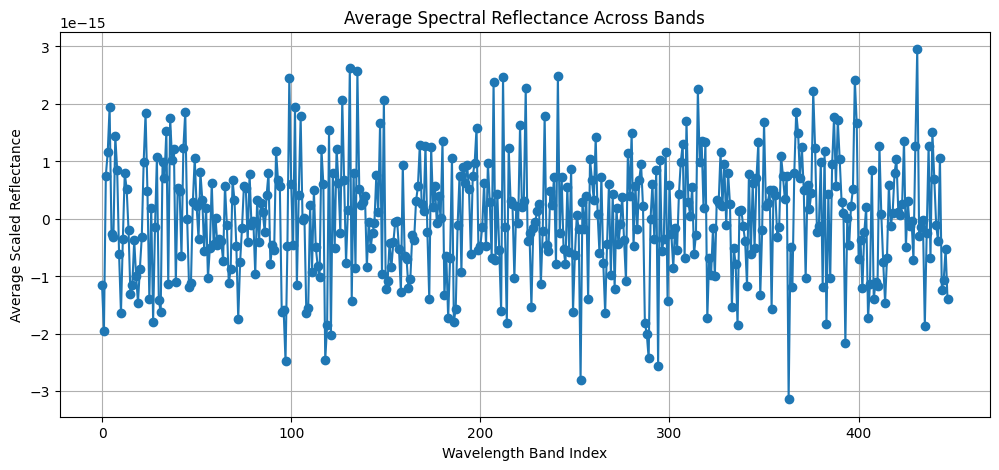

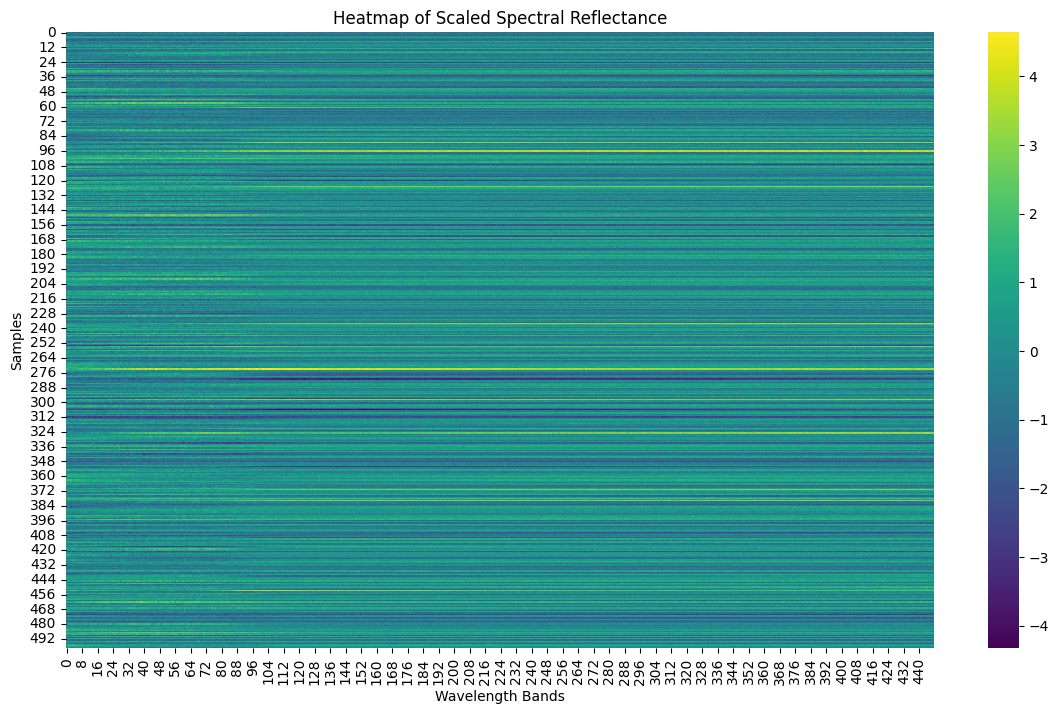

Number of PCA components selected: 3
Explained variance ratio: [0.87077909 0.05849069 0.02112294]


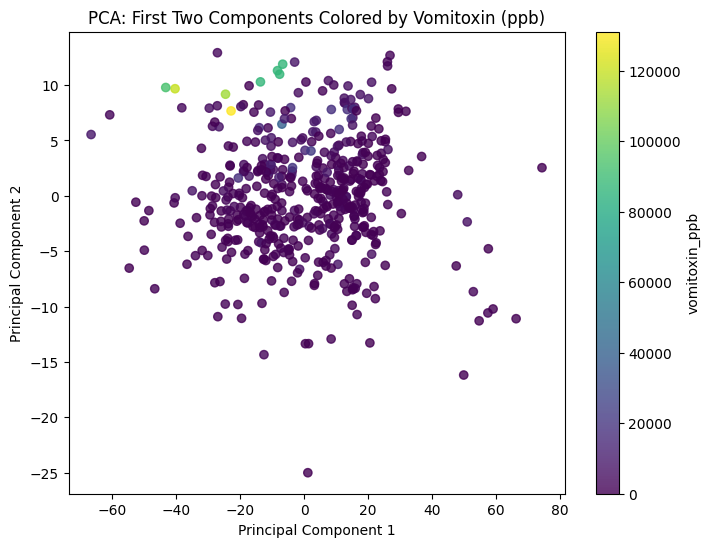

Best hyperparameters: {'max_depth': 10, 'n_estimators': 50}

Evaluation Metrics:
Mean Absolute Error (MAE): 3967.272
Root Mean Squared Error (RMSE): 12347.868
R² Score: 0.455


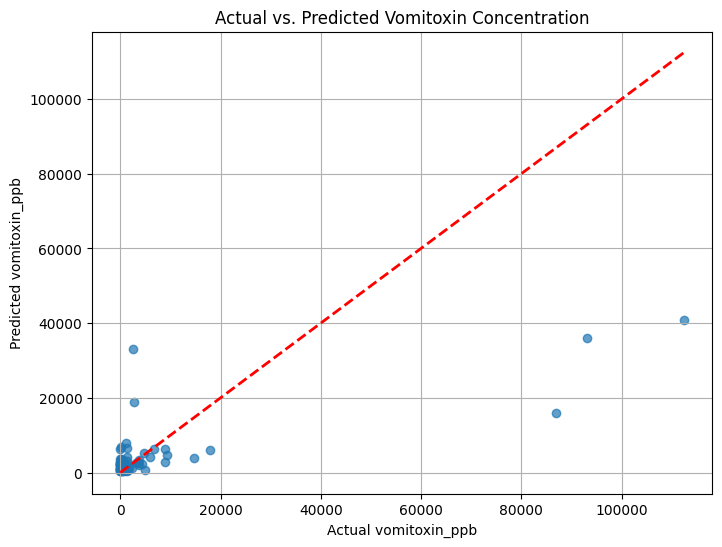

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------
# 1. Data Loading and Preprocessing
# ---------------------------

# Load the CSV file.
# If your CSV is tab-separated (as it appears), specify the delimiter.
data = pd.read_csv("/content/TASK-ML-INTERN.csv")

# Display the first few rows and a summary of the data.
print("Data Head:")
print(data.head())
print("\nData Info:")
print(data.info())

# Check for missing values (if any)
print("\nMissing Values by Column:")
print(data.isnull().sum())

# Assuming the first column is an identifier and the last column is the target,
# we separate the features and target variable.
target_column = "vomitoxin_ppb"
identifier_column = "hsi_id"
feature_columns = [col for col in data.columns if col not in [identifier_column, target_column]]

# Separate features and target
X = data[feature_columns]
y = data[target_column]

# Normalize the spectral data using StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# 2. Data Visualization (EDA)
# ---------------------------

# Plot the average scaled reflectance across wavelength bands.
avg_reflectance = np.mean(X_scaled, axis=0)
plt.figure(figsize=(12, 5))
plt.plot(avg_reflectance, marker='o')
plt.xlabel("Wavelength Band Index")
plt.ylabel("Average Scaled Reflectance")
plt.title("Average Spectral Reflectance Across Bands")
plt.grid(True)
plt.show()

# Plot a heatmap to visualize the spectral values across samples.
plt.figure(figsize=(14, 8))
sns.heatmap(X_scaled, cmap='viridis', cbar=True)
plt.title("Heatmap of Scaled Spectral Reflectance")
plt.xlabel("Wavelength Bands")
plt.ylabel("Samples")
plt.show()

# ---------------------------
# 3. Dimensionality Reduction with PCA
# ---------------------------

# Apply PCA to reduce dimensions; here we keep enough components to explain 95% variance.
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
print("Number of PCA components selected:", pca.n_components_)
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Visualize the first two principal components.
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.8)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: First Two Components Colored by Vomitoxin (ppb)")
plt.colorbar(scatter, label="vomitoxin_ppb")
plt.show()

# ---------------------------
# 4. Model Training: Predicting Vomitoxin Concentration
# ---------------------------

# Split the dataset into training and testing sets (80/20 split).
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Set up a Random Forest Regressor and define a hyperparameter grid.
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

# Perform grid search with 5-fold cross-validation.
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Best model from grid search.
best_rf = grid_search.best_estimator_
print("Best hyperparameters:", grid_search.best_params_)

# ---------------------------
# 5. Model Evaluation
# ---------------------------

# Predict vomitoxin concentration on the test set.
y_pred = best_rf.predict(X_test)

# Compute evaluation metrics.
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

# Plot Actual vs Predicted vomitoxin concentrations.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual vomitoxin_ppb")
plt.ylabel("Predicted vomitoxin_ppb")
plt.title("Actual vs. Predicted Vomitoxin Concentration")
plt.grid(True)
plt.show()